[*********************100%%**********************]  1 of 1 completed


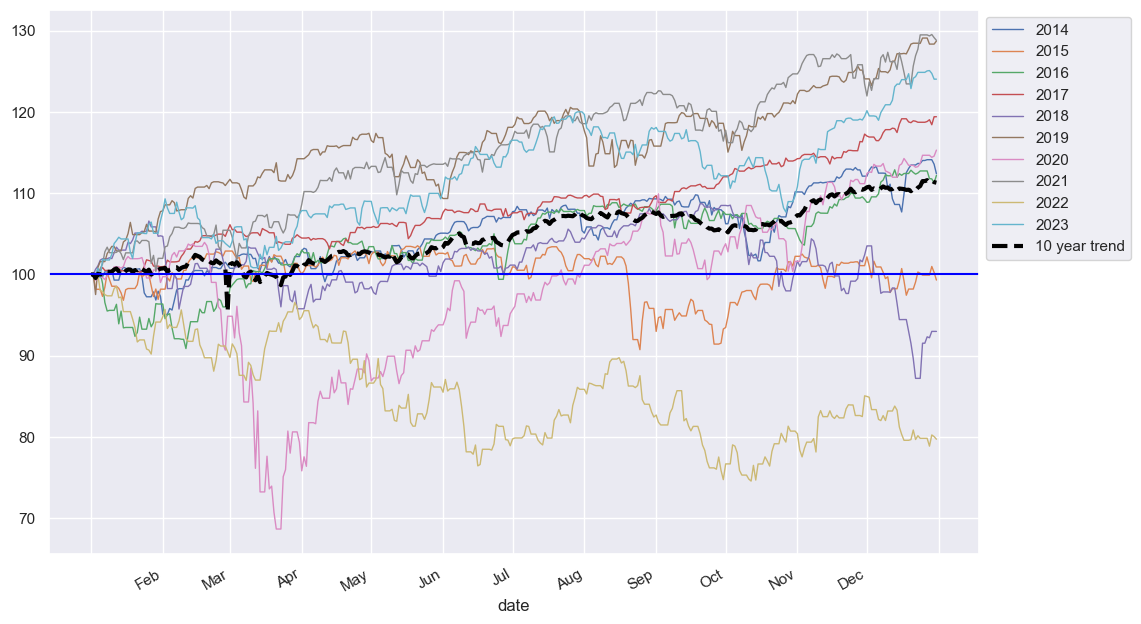

In [176]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import seaborn as sns

# Part 1

# Import SP500 index for 2014-2023
start_date = '2014-01-01'
end_date = '2024-01-03' # Get data a few days past end of year to backfill
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])

all_dates = pd.date_range(start_date, end_date)
spx['Price Date'] = spx.index

# Fill in missing prices with the first price after the date
# This would be "forward-looking" if we were trading off of prices, but
# we are trading off of specific dates so we do not see into the future
spx = spx.reindex(all_dates, method='bfill')

# Drop data for 2024
spx = spx[spx.index < '2024-01-01']

# Normalize prices relative to first of the year
spx['Year'] = spx.index.year
spx['Month Day'] = spx.index.strftime('%m-%d')
spx['Yr Init Price'] = spx.groupby('Year', sort=False).transform(
    'first')['Adj Close']
spx['Seasonal Trend Price'] = spx['Adj Close'] / spx['Yr Init Price'] * 100

# Now take averages over the last 10 years
spx10yr = spx[['Month Day','Seasonal Trend Price']].groupby('Month Day').mean()
spx10yr['plot date'] = list(spx10yr.reset_index()['Month Day'].apply(
    lambda x: datetime.strptime("2000-" + x, "%Y-%m-%d")))

# Plot
fig, ax = plt.subplots()
for label, dfy in spx.assign(
        date=pd.to_datetime(spx.index.strftime('2000-%m-%d')),
        year=spx.index.strftime('%Y')
).groupby('year'):
    dfy.set_index('date')['Seasonal Trend Price'].plot(ax=ax, label=str(label),
        linewidth=1)

ax.plot(spx10yr['plot date'], spx10yr['Seasonal Trend Price'],
        label='10 year trend', linewidth=3.0, linestyle='dashed', color='black')
ax.axhline(y=100, color='blue')

locator = mdates.MonthLocator()  # every month
formatter = mdates.ConciseDateFormatter(
    locator,
    formats=['', '%b', '%d', '%H:%M', '%H:%M', '%S.%f'],
    offset_formats=['', '', '%b', '%b-%d', '%b-%d', '%b-%d %H:%M']
)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

[*********************100%%**********************]  1 of 1 completed


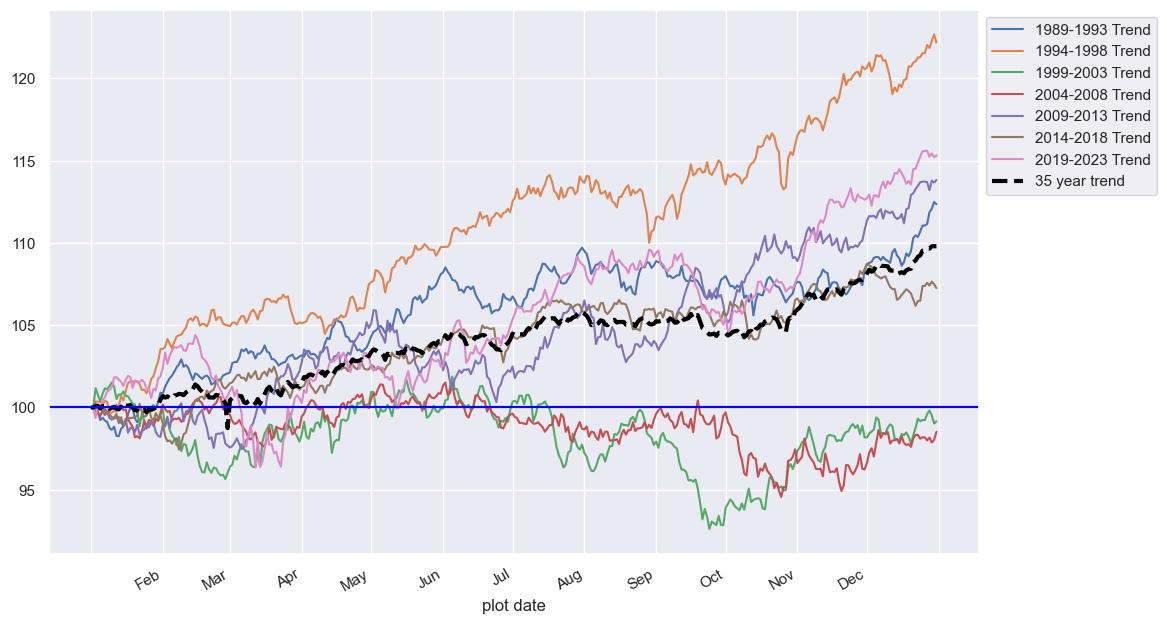

In [177]:
# Part 2

# Over the last 10 years, the annual returns to holding the SP500 averaged ~11%
# Note from the graph that the average upward trend tends to start in Apr:
# holding from Jan 1 to Mar 31 averaged only a 0.75% return.
# Is this seasonal behavior something we see going even further back?

start_date = '1989-01-01'
end_date = '2024-01-05'
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])

all_dates = pd.date_range(start_date, end_date)
spx['Price Date'] = spx.index
spx = spx.reindex(all_dates, method='bfill')
spx = spx[spx.index < '2024-01-01']
spx['Year'] = spx.index.year
spx['Month Day'] = spx.index.strftime('%m-%d')
spx['Yr Init Price'] = spx.groupby('Year', sort=False).transform(
    'first')['Adj Close']
spx['Seasonal Trend Price'] = spx['Adj Close'] / spx['Yr Init Price'] * 100

spx['Yr Group'] = np.select(
    condlist=[spx.Year < 1994, spx.Year < 1999, spx.Year < 2004,
              spx.Year < 2009, spx.Year < 2014, spx.Year < 2019],
    choicelist=['1989-1993 Trend', '1994-1998 Trend', '1999-2003 Trend',
                '2004-2008 Trend', '2009-2013 Trend', '2014-2018 Trend'],
    default='2019-2023 Trend')

# Plot
fig, ax = plt.subplots()
spx5yr = spx.groupby(['Month Day', 'Yr Group']).mean()
spx5yr['plot date'] = list(spx5yr.reset_index()['Month Day'].apply(
    lambda x: datetime.strptime("2000-" + x, "%Y-%m-%d")))

# Feb 29 causes "spikes" in the 5-year averages, so remove it
spx5yr = spx5yr[spx5yr['plot date'] != '2000-02-29']

for label, dfy in spx5yr.groupby('Yr Group'):
    dfy.set_index('plot date')['Seasonal Trend Price'].plot(
        ax=ax, label=str(label))

spxavg = spx[['Month Day','Seasonal Trend Price']].groupby('Month Day').mean()
spxavg['plot date'] = list(spxavg.reset_index()['Month Day'].apply(
    lambda x: datetime.strptime("2000-" + x, "%Y-%m-%d")))

ax.plot(spxavg['plot date'], spxavg['Seasonal Trend Price'],
        label='35 year trend', linewidth=3.0, linestyle='dashed', color='black')
ax.axhline(y=100, color='blue')

locator = mdates.MonthLocator()  # every month
formatter = mdates.ConciseDateFormatter(
    locator,
    formats=['', '%b', '%d', '%H:%M', '%H:%M', '%S.%f'],
    offset_formats=['', '', '%b', '%b-%d', '%b-%d', '%b-%d %H:%M'])

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax.axhline(y=100, color='blue')


In [178]:
# Part 3

# Looking back 35 years instead of just 10, it seems the SP500 has close to
# zero gains in Jan-Feb rather than Jan-Mar (this is also true for just the last
# 10 years).

# Let's compare three strategies:
# 1) Holding 3-month "risk-free" T-bills all year
# 2) Holding the SP500 all year
# 3) Holding a 3-month T-bill from Jan 1 to Mar 1 (2 mos.) and then
#    reinvesting in the SP500 from Mar 1 to Dec 31

# Strat 1: "Risk-free" 3-month T-bills. Assume we buy on Jan 1 for Apr 1 mat.,
# then repeat on Apr 1 for Jul 1 mat., Jul 1 for Oct 1, Oct 1 for Jan 1
# Tbill.csv is pulled from https://fred.stlouisfed.org/series/DTB3
# and has annualized rates: divide by 12/3 = 4 to get 3-month returns

tbill = pd.read_csv('Tbill.csv')
tbill['Year'] = tbill.DATE.str.slice(stop=4).astype(int)
tbill['month'] = tbill.DATE.str.slice(start=5, stop=7)

# Take T-bill returns on months 1, 4, 7, 10. TB3MS is reported in annualized
# percent, so divide by 4 * 100. Multiply for each quarter, then subtract 1
tbill_strategy = (tbill[tbill.month.isin(['01', '04', '07', '10'])].assign(
    bondreturn=1 + tbill.TB3MS / (4 * 100)
).groupby('Year').bondreturn.prod() - 1).reset_index(name='T-bill return')

# Strat 2: Hold SP500: buy as soon as possible after Jan 1 and sell as soon as
# possible after Dec 31
def yearly_return(x):
    start_val = x[x['Month Day'] == '01-01']['Adj Close'].values[0]
    end_val = x[x['Month Day'] == '12-31']['Adj Close'].values[0]
    return end_val / start_val - 1

sp500_strategy = spx.groupby('Year').apply(yearly_return).reset_index(
    name='SP500 return')


# Strat 3: Buy 3 month T-bill on Jan 1, sell it on Mar 1 (collecting 2 mos'
# "interest"), then buy SP500 on Mar 1 and close out ASAP after Dec 31
# For simplicity, set T-bill yield to 1/6 the annualized value reported on Jan 1

def mar_return(x):
    start_val = x[x['Month Day'] == '03-01']['Adj Close'].values[0]
    end_val = x[x['Month Day'] == '12-31']['Adj Close'].values[0]
    return end_val / start_val - 1

mar_returns = spx.groupby('Year').apply(mar_return).reset_index(
    name='Mar onwards SP500 return')

tbill_jan_returns = tbill[tbill.month == '01']
seasonal_strategy = mar_returns.merge(tbill_jan_returns, on='Year', how='left')
seasonal_strategy['Seasonal return'] = (
        (seasonal_strategy['Mar onwards SP500 return'] + 1) * (
        1 + seasonal_strategy['TB3MS'] / (6 * 100)) - 1)

In [179]:
# Part 4

# Compare simple SP500 to seasonal strat, and compute Sharpe/Sortino ratios off
# annual returns, using T-bill strat as the risk-free baseline
strats = tbill_strategy[['Year', 'T-bill return']].merge(
    sp500_strategy[['Year', 'SP500 return']], on='Year').merge(
    seasonal_strategy[['Year', 'Seasonal return']], on='Year')

strats['SP500 excess'] = strats['SP500 return']-strats['T-bill return']
strats['Seasonal excess'] = strats['Seasonal return']-strats['T-bill return']


def sharpe(df, strat_name, risk_free):
    excess_return = df[strat_name]-df[risk_free]
    return excess_return.mean()/excess_return.std()

def sortino(df, strat_name, risk_free, threshold):
    excess_return = df[strat_name]-df[risk_free]
    downside = excess_return[(excess_return<df[threshold])]
    denom = np.sqrt(sum(downside*downside)/len(downside))
    return excess_return.mean()/denom

df = pd.DataFrame(
    {'Strategy' : ['SP500','Seasonal SP500'],
    'Mean Excess Return' : [strats['SP500 excess'].mean(),
    strats['Seasonal excess'].mean()],
    'Excess Return Ann Vol': [strats['SP500 excess'].std(),
    strats['Seasonal excess'].std()],
    'Sharpe Ratio' : [sharpe(strats,'SP500 return','T-bill return'),
    sharpe(strats,'Seasonal return','T-bill return')],
    'Sortino Ratio' : [sortino(strats,'SP500 return','T-bill return',
        'T-bill return'),sortino(strats,'Seasonal return','T-bill return',
        'T-bill return')]})

# Repeat for just last 10 years
strats_sub = strats[strats.Year>=2014]

df_sub = pd.DataFrame(
    {'Strategy' : ['SP500','Seasonal SP500'],
    'Mean Excess Return' : [strats_sub['SP500 excess'].mean(),
    strats_sub['Seasonal excess'].mean()],
    'Excess Return Ann Vol': [strats_sub['SP500 excess'].std(),
    strats_sub['Seasonal excess'].std()],
    'Sharpe Ratio' : [sharpe(strats_sub,'SP500 return','T-bill return'),
    sharpe(strats_sub,'Seasonal return','T-bill return')],
    'Sortino Ratio' : [sortino(strats_sub,'SP500 return','T-bill return',
        'T-bill return'), sortino(strats_sub,'Seasonal return','T-bill return',
        'T-bill return')]})


In [181]:
df
df_sub

,Strategy,Mean Excess Return,Excess Return Ann Vol,Sharpe Ratio,Sortino Ratio
0,SP500,0.100261,0.160045,0.626453,0.731873
1,Seasonal SP500,0.085642,0.122646,0.698288,0.951997


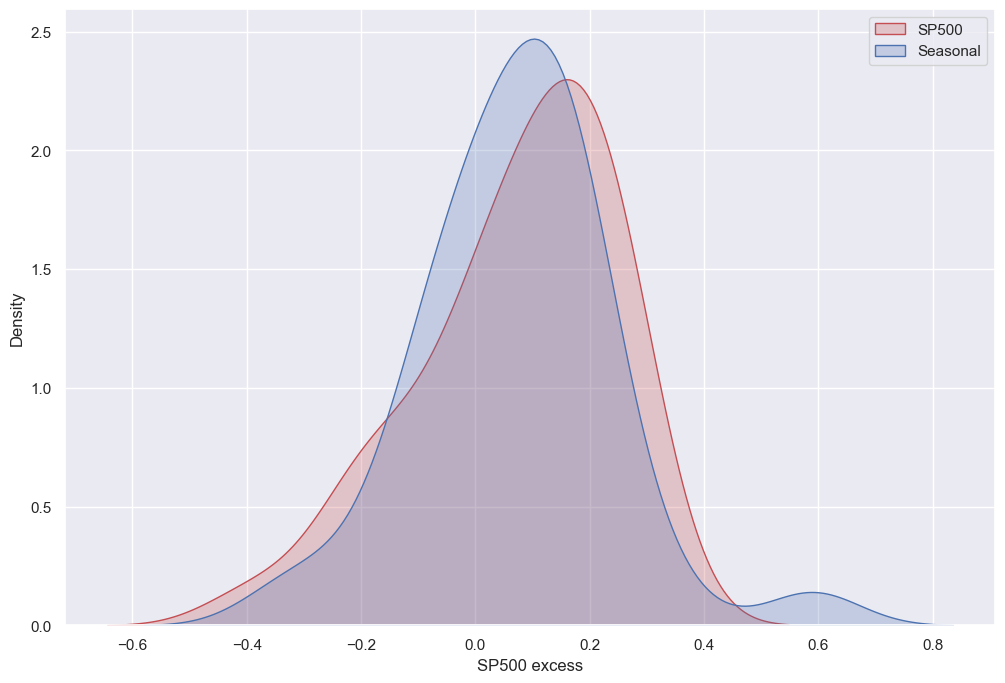

In [188]:
# plotting both distibutions on the same figure
fig = sns.kdeplot(strats['SP500 excess'], fill=True, color="r",label='SP500')
fig = sns.kdeplot(strats['Seasonal excess'], fill=True, color="b",label='Seasonal')
fig.legend(loc='upper right')

plt.show()


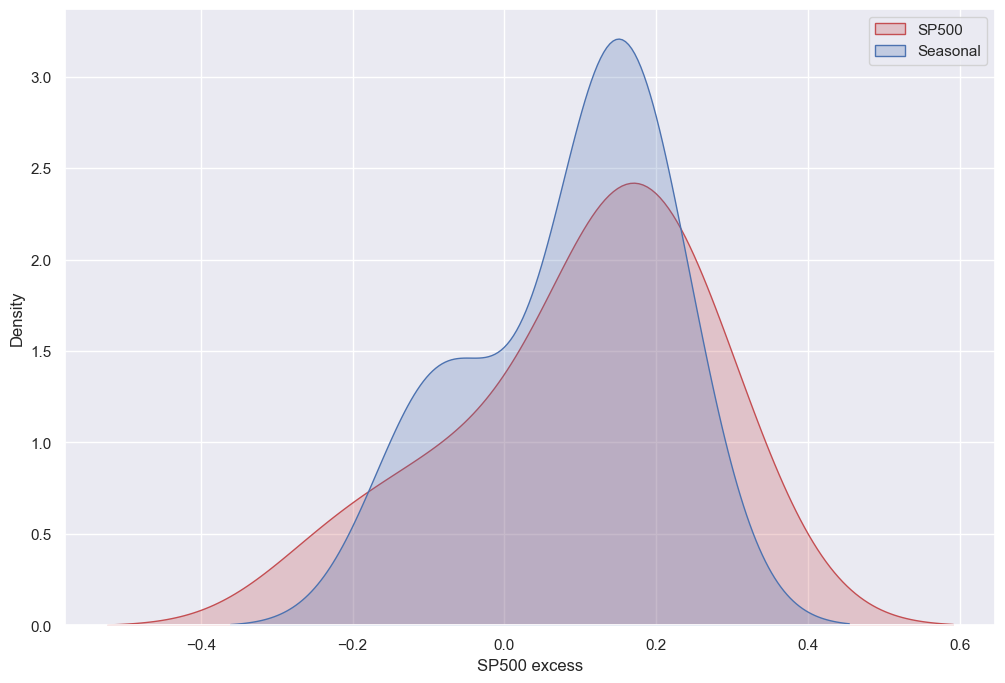

In [189]:
fig = sns.kdeplot(strats_sub['SP500 excess'], fill=True, color="r",label='SP500')
fig = sns.kdeplot(strats_sub['Seasonal excess'], fill=True, color="b",label='Seasonal')
fig.legend(loc='upper right')

plt.show()